# Convergence analysis of finite element solutions

This notebook draws heavily from the article [Axisymmetric formulation for elastic structures of revolution](https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/axisymmetric_elasticity.html#Axisymmetric-formulation-for-elastic-structures-of-revolution) by J. Bleyer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mshr
import dolfin
%matplotlib inline
plt.rcParams['figure.figsize']=(12, 8)

## Parameters of the simulation

The cylinder is defined by its mean radius, $R$, and its thickness $h$. In cylindrical coordinates $(r, \theta, z)$, the domain is therefore defined by $R-h/2\leq r\leq R+h/2$.

In [2]:
radius = 1.
thickness = radius/20.0

Change the following parameter if you wish to refine the mesh.

In [3]:
element_size = thickness/5.

## Mesh generation

The `mshr` module uses the [Constructive Geometry](https://en.wikipedia.org/wiki/Constructive_solid_geometry) paradigm. The whole cross-section of the cylinder is therefore defined as the difference of the disk with radius $(r+h/2)$ and the disk with radius $(r+h/2)$.

Owing to symmetries, it is sufficient to model the upper-right quarter of the cross-section. We therefore subtract the top-left quadrant, and the rectangle made of the two lower quadrants.

161


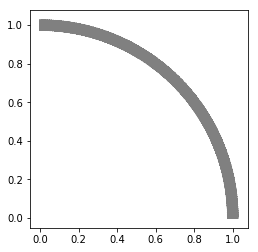

In [4]:
r_out = radius+0.5*thickness
r_in = radius-0.5*thickness

p0 = dolfin.Point(0., 0.)
p1 = dolfin.Point(-r_out, r_out)
p2 = dolfin.Point(-r_out, -r_out)
p3 = dolfin.Point(r_out, 0)

num_elements = int(2*np.pi*r_out/element_size/4)
print(num_elements)

domain = (mshr.Circle(p0, r_out,num_elements) -
          mshr.Circle(p0, r_in,num_elements) -
          mshr.Rectangle(p0, p1) -
          mshr.Rectangle(p2, p3))
mesh = mshr.generate_mesh(domain,num_elements)
dolfin.plot(mesh);

## Boundary indicators

The machinery below is needed to mark the boundaries of the domain and selectively impose on them the boundary conditions.
This is a delicate part of the finite element implementation, because often the 'devil is in the boundary conditions'!.

We refer to the FEniCs tutorial, sec 4.4.2 and 4.4.3 for details and syntax on that. 

In [5]:
tol = 1E-14
inner = dolfin.CompiledSubDomain('hypot(x[0], x[1]) <= r_in+tol', tol=tol, r_in=radius-0.5*thickness)
outer = dolfin.CompiledSubDomain('hypot(x[0], x[1]) >= r_out+tol', tol=tol, r_out=radius+0.5*thickness)
left = dolfin.CompiledSubDomain('x[0] <= tol', tol=tol)
bottom = dolfin.CompiledSubDomain('x[1] <= tol', tol=tol)

This assign a function defiend on the facets of the mesh, assigning to each facet an index, that we can use to impose boundary conditions

In [6]:
facets = dolfin.MeshFunction('size_t', mesh, 1)
facets.set_all(0)
bottom.mark(facets, 1)
outer.mark(facets, 2)
left.mark(facets, 3)
inner.mark(facets, 4)

We can save this function to a file, so that you can check the values of the indicators with paraview

In [7]:
with dolfin.XDMFFile(mesh.mpi_comm(), "output/boundaries.xdmf") as file: 
    file.write(facets)

## Strain-displacement operator

In 2D elasticity, the spatial coordinates are $x=$ `x[0]` and $y=$ `x[1]`.

In [8]:
def eps(u):
    return dolfin.sym(dolfin.grad(u))

## Stress-strain operator

The stress-strain operator defined below corresponds to plane strain elasticity

In [9]:
mu = dolfin.Constant(1.0)
nu = dolfin.Constant(0.3)
lmbda = 2.*mu*nu/(1.-2.*nu)

In [10]:
I2 = dolfin.Identity(2)

In [11]:
def sig(epsilon):
    return  2.*mu*epsilon+lmbda*dolfin.tr(epsilon)*I2

## Variational formulation

In [12]:
p_out = dolfin.Constant(0.)
p_in = dolfin.Constant(1.)

In [13]:
element = dolfin.VectorElement('P', dolfin.triangle, degree=1, dim=2)
V = dolfin.FunctionSpace(mesh, element)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

In [14]:
ds = dolfin.Measure("ds", subdomain_data=facets)
n = dolfin.FacetNormal(mesh)

a = dolfin.inner(sig(eps(u)), eps(v))*dolfin.dx 
L = dolfin.inner(-p_in*n, v)*ds(4)+dolfin.inner(-p_out*n, v)*ds(2)

## Boundary conditions

Both $xx$ and $yy$ axes are axes of symmetry.

In [15]:
bcs = [dolfin.DirichletBC(V.sub(0), 0., left),
       dolfin.DirichletBC(V.sub(1), 0., bottom)]

In [16]:
u = dolfin.Function(V)
problem = dolfin.LinearVariationalProblem(a, L, u, bcs)
solver = dolfin.LinearVariationalSolver(problem)
solver.solve()

We can check (visually) that the displacement is radial.

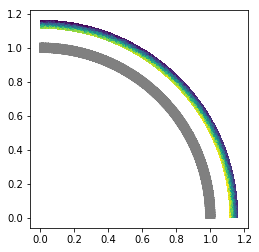

In [17]:
dolfin.plot(mesh)
dolfin.plot(0.02*u, mode = "displacement")

## Comparison with exact solution

It can be shown that the exact displacement is radial ($\mathbf{u}=u(r)\,\mathbf{e}_r$), with

\begin{equation}
u(r)=Ar+\frac Br, \quad
A = \frac{p}{2\mu}\bigl(1-2\nu\bigr)\Bigl[\frac{\varpi}{4\eta}\bigl(1+\eta^2\bigr)-1\Bigr]
\quad\text{and}\quad
B = \frac{p\varpi R^2}{8\eta\mu}\bigl(1-\eta^2\bigl)^2,
\end{equation}

where we have introduced

\begin{equation}
\eta=\frac{h}{2R},\quad
p = \frac{p_\mathrm{in}+p_\mathrm{out}}{2}
\quad\text{and}\quad
\varpi = \frac{p_\mathrm{in}-p_\mathrm{out}}{p}.
\end{equation}

It can readily be verified that the above expressions indeed define the solution to the problem at hand. Alternatively, this notebook **TODO: add link** uses symbolic computations to derive the solution.

We compare the finite element solution obtained above with the reference solution. We first compute the integration constants $A$ and $B$.

In [18]:
def valueof(const):
    return const.values()[0]

p = (valueof(p_in)+valueof(p_out))/2.
varpi = (valueof(p_in)-valueof(p_out))/p
eta = thickness/2/radius

A = p*(1-2*valueof(nu))*(varpi/4./eta*(1+eta**2)-1)/2./valueof(mu)
B = p*varpi*radius**2*(eta**2-1)**2/8./eta/valueof(mu)


We then plot the FE solution along a line $\theta=\mathrm{const.}$. The purpose of `atol` defined below is to avoid error messages, by making the line a little bit shorter than the thickness of the shell.

In [19]:
atol = 1E-3
r = np.linspace(radius-0.5*(1-atol)*thickness,
                radius+0.5*(1-atol)*thickness, num=100)
theta = np.pi/3.
xy = r[..., None]*[np.cos(theta), np.sin(theta)]
u_r_ref = A*r+B/r

In [20]:
u.set_allow_extrapolation(True)
u_r_fem = np.empty_like(xy[..., 0])
for k in range(xy.shape[0]):
    u_r_fem[k] = np.linalg.norm(u(xy[k]))

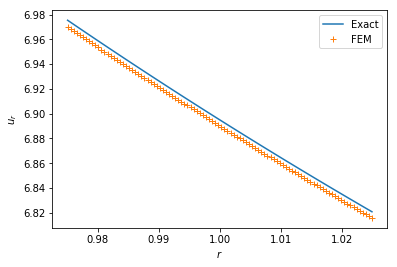

In [21]:
plt.plot(r, u_r_ref, label='Exact')
plt.plot(r, u_r_fem, '+', label='FEM')
plt.xlabel('$r$')
plt.ylabel('$u_r$')
plt.legend();

We can also represent the exact solution as an expression, to interpolate on the FE mesh

In [22]:
degree = 4
r_ = dolfin.Expression("sqrt(pow(x[0],2)+pow(x[1],2))",degree=degree)
theta_ = dolfin.Expression("atan2(x[1],x[0])",degree=degree)
u_r_ref = dolfin.Expression("A*r+B/r",r=r_,theta=theta_,A=A,B=B,degree=degree)
u_ref = dolfin.Expression(("u*cos(theta)","u*sin(theta)"),u=u_r_ref,theta=theta_,degree=degree)

and calculate the L2 norm of the error w.r.t the FE solution. We refer to section 5.5 of the FEniCS tutorial for further details on computing the norm of the error

In [24]:
errorL2 = dolfin.errornorm(u_ref,u,'L2')
normu = dolfin.assemble(dolfin.inner(u,u)*dolfin.dx)
print("The  L2 % error is ", errorL2/normu*100)

The  L2 % error is  0.05400719845082862


There is an excellent agreement between the exact and numerical solutions. In order to get more quantitative results (in particular, in order to estimate the convergence rate), we first need to factor the above code into a single class, that can. This will be done in the next notebook **TODO: add link**.